In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
import scipy.stats as stats
from imblearn.over_sampling import SMOTE
from collections import Counter
import pickle
import json

In [2]:
def perform_SMOTE(X, y):
    sm = SMOTE(random_state=42)
    print('Original dataset shape %s' % Counter(y))
    X_res, y_res = sm.fit_resample(X, y)
    print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

In [3]:
train_dataset_path = "/scratch/sshuvo13/project_shared_folder_bspml_1/segments_30s/features/train_test_separated_and_combined/male/feature33/train_data.csv"
test_dataset_path = "/scratch/sshuvo13/project_shared_folder_bspml_1/segments_30s/features/train_test_separated_and_combined/male/feature33/test_data.csv"

In [4]:
train_dataset = pd.read_csv(train_dataset_path)

In [5]:
test_dataset = pd.read_csv(test_dataset_path)

In [6]:
X_train_unscaled = train_dataset.iloc[:, :-1]
y_train = train_dataset.iloc[:, -1]

X_test_unscaled = test_dataset.iloc[:, :-1]
y_test = test_dataset.iloc[:, -1]

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_unscaled)
X_test_scaled = scaler.transform(X_test_unscaled)

In [8]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [9]:
print(f"classes are: {le.classes_}")

classes are: ['Apnea' 'Normal']


In [10]:
X_train_scaled, y_train = perform_SMOTE(X_train_scaled, y_train)

Original dataset shape Counter({0: 61097, 1: 33183})
Resampled dataset shape Counter({1: 61097, 0: 61097})


In [11]:
# X_train.shape

In [12]:
RF_obj = RandomForestClassifier(n_jobs = -1)
kf = StratifiedKFold(n_splits=5, shuffle=True) # k-fold
# Running randomized search to fine the best hyper-parameter set
# param_dist = {
#     'n_estimators': [100, 200, 500, 1000],  
#     'max_depth': [None, 5, 10, 20, 30, 50, 70, 100],  
#     'min_samples_split': [2, 5, 10, 20, 50],  
#     'min_samples_leaf': [1, 2, 4, 8, 16],  
#     'max_features': ['sqrt', 'log2', None, 0.3, 0.5, 0.7],  
#     'bootstrap': [True, False],  
#     'class_weight': [None, 'balanced', 'balanced_subsample'], 
#     'criterion': ['gini', 'entropy', 'log_loss'],  
# }


param_dist = {
    'n_estimators': [100, 200 ],  
    'max_depth': [20, 50],  
    'min_samples_split': [10, 20 ],  
    'min_samples_leaf': [ 4, 8],  
    'max_features': ['log2'],  
    'bootstrap': [True],  
    'class_weight': [None,'balanced_subsample'], 
    'criterion': ['gini','entropy'],  
}


n_iter_search = 10
random_search = RandomizedSearchCV(RF_obj, param_distributions = param_dist, n_iter = n_iter_search, cv= kf, scoring='roc_auc', verbose = 2)
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, class_weight=None, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=20, n_estimators=100; total time=   5.3s
[CV] END bootstrap=True, class_weight=None, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=20, n_estimators=100; total time=   7.3s
[CV] END bootstrap=True, class_weight=None, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=20, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, class_weight=None, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=20, n_estimators=100; total time=   7.0s
[CV] END bootstrap=True, class_weight=None, criterion=entropy, max_depth=20, max_features=log2, min_samples_leaf=8, min_samples_split=20, n_estimators=100; total time=   4.7s
[CV] END bootstrap=True, class_weight=balanced_subsample, criter

,estimator,RandomForestC...ier(n_jobs=-1)
,param_distributions,"{'bootstrap': [True], 'class_weight': [None, 'balanced_subsample'], 'criterion': ['gini', 'entropy'], 'max_depth': [20, 50], ...}"
,n_iter,10
,scoring,'roc_auc'
,n_jobs,None
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [13]:
target_names= le.classes_

In [45]:
best_model = random_search.best_estimator_
best_model.verbose = True
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)
y_scores = best_model.predict_proba(X_test_scaled)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.1s finished


In [46]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
# confusion_matrix

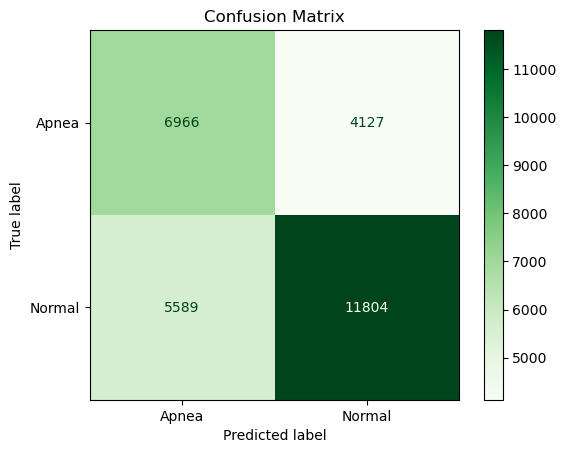

In [47]:
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_, cmap = 'Greens');
disp.ax_.set_title("Confusion Matrix")
plt.savefig("./outputs/confusion_matrix.png", dpi=300, bbox_inches="tight")

In [48]:
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

       Apnea       0.55      0.63      0.59     11093
      Normal       0.74      0.68      0.71     17393

    accuracy                           0.66     28486
   macro avg       0.65      0.65      0.65     28486
weighted avg       0.67      0.66      0.66     28486



In [49]:
evaluation_metrics_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict = True)

In [50]:
print(f"Sensitivity is : {evaluation_metrics_dict['Apnea']['recall']}")
print(f"Specificity is : {evaluation_metrics_dict['Normal']['recall']}")

Sensitivity is : 0.6279635806364374
Specificity is : 0.6786638302765481


In [51]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_pred)

In [52]:
# plt.plot(recall, precision)
# plt.xlabel("Recall")
# plt.ylabel("Precision")
# plt.title("Precision-Recall Curve")

In [53]:
print(f"Area under the precision recall curve: {metrics.auc(recall, precision)}")

Area under the precision recall curve: 0.8079053999551711


In [54]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)

In [55]:
# plt.plot(fpr, tpr)
# plt.xlabel("Fall positive rate")
# plt.ylabel("True positive rate")
# plt.title("Receiver Operating Characteristics Curve")

In [56]:
print(f"Area under the ROC curve: {metrics.auc(fpr, tpr)}")

Area under the ROC curve: 0.6533137054564928


In [57]:
# storing variables for later comparison

random_forest_metrics = {'true_label':y_test, 
                   'predicted_label':y_pred, 
                   'sensitivity':evaluation_metrics_dict['Apnea']['recall'],
                   'specificity': evaluation_metrics_dict['Normal']['recall'],
                   'precision':evaluation_metrics_dict['weighted avg']['precision'],
                   'recall':evaluation_metrics_dict['weighted avg']['recall'],
                   'f1-score':evaluation_metrics_dict['weighted avg']['f1-score'],
                   'tpr':tpr,
                   'fpr':fpr,
                   'AUC_PR':metrics.auc(recall, precision),
                   'AUC_ROC':metrics.auc(fpr, tpr)                  
                  }

for key, value in random_forest_metrics.items():
    if isinstance(value, np.ndarray):
        random_forest_metrics[key] = value.tolist()

output_dir = "./outputs/classification_metrics_for_comparison/"
os.makedirs(output_dir, exist_ok = True)
with open( os.path.join(output_dir, "random_forest_metrics.json"), "w") as file:
    json.dump(random_forest_metrics, file)

In [ ]:
# Jupyter cell: Precision-Recall and ROC plots with AUC
# Assumes: you already have `y_test` and `y_pred` as numpy ndarrays in the notebook.
# y_test: ground truth (0 = normal, 1 = Apnea)
# y_pred: either predicted probability/scores for class 1, or binary predictions (0/1).
# If y_pred contains only 0/1, it will still plot curves but treat those values as scores (less informative).

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_curve,
    roc_auc_score,
    PrecisionRecallDisplay,
    RocCurveDisplay
)

# # Make sure they are 1-D numpy arrays
# y_test = np.asarray(y_test).ravel()
# y_pred = np.asarray(y_pred).ravel()

# # Basic validation
# if y_test.shape[0] != y_pred.shape[0]:
#     raise ValueError(f"Length mismatch: y_test has length {y_test.shape[0]} but y_pred has length {y_pred.shape[0]}")

# # Decide whether y_pred are probabilities/scores or binary labels
# unique_vals = np.unique(y_pred)
# is_binary_pred = np.array_equal(unique_vals, [0]) or np.array_equal(unique_vals, [1]) or np.array_equal(unique_vals, [0,1])

# if is_binary_pred:
#     print("Warning: y_pred contains only binary values (0/1). "
#           "Precision-Recall and ROC curves will be computed from those discrete scores. "
#           "If possible, use predicted probabilities or decision scores for more informative curves.")
#     # use the binary predictions as "scores" (they're discrete)
#     y_scores = y_pred.astype(float)
# else:
#     # If values look like probabilities or continuous scores, use them directly
#     y_scores = y_pred.astype(float)

# --- Precision-Recall ---
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_scores, pos_label=1)
avg_prec = average_precision_score(y_test, y_scores, pos_label=1)  # average precision (area under PR curve)

# Plot Precision-Recall
plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post')      # step plot is conventional for PR
plt.fill_between(recall, precision, step='post', alpha=0.2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall curve (pos label = 1) — Average Precision (AP) = {avg_prec:.4f}')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(True)
plt.show()

# --- ROC Curve ---
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores, pos_label=1)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], linestyle='--', alpha=0.7)  # chance line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title(f'ROC curve (pos label = 1) — AUC = {roc_auc:.4f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()

# Optional: show a small table of thresholds near the operating points (useful if discrete predictions)
if is_binary_pred:
    # Show unique thresholds and associated TPR/FPR/Precision/Recall for the discrete scores
    print("\nDiscrete score summary (unique scores present in y_pred):")
    uniq_scores = np.unique(y_scores)[::-1]  # descending
    summary = []
    for s in uniq_scores:
        y_hat = (y_scores >= s).astype(int)
        # compute metrics quickly
        tp = int(np.sum((y_hat == 1) & (y_test == 1)))
        fp = int(np.sum((y_hat == 1) & (y_test == 0)))
        fn = int(np.sum((y_hat == 0) & (y_test == 1)))
        tn = int(np.sum((y_hat == 0) & (y_test == 0)))
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr_val = fp / (fp + tn) if (fp + tn) > 0 else 0.0
        summary.append((s, tp, fp, fn, tn, prec, rec, fpr_val))
    # Print
    print("score | TP | FP | FN | TN | precision | recall | fpr")
    for row in summary:
        print(f"{row[0]:>5} | {row[1]:>2} | {row[2]:>2} | {row[3]:>2} | {row[4]:>2} | {row[5]:.3f}     | {row[6]:.3f}  | {row[7]:.3f}")

# If you want both curves in a single figure side-by-side:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
# PR plot
axes[0].step(recall, precision, where='post')
axes[0].fill_between(recall, precision, step='post', alpha=0.2)
axes[0].set_xlabel('Recall')
axes[0].set_ylabel('Precision')
axes[0].set_title(f'PR curve — AP = {avg_prec:.4f}')
axes[0].set_xlim([0,1])
axes[0].set_ylim([0,1.05])
axes[0].grid(True)

# ROC plot
axes[1].plot(fpr, tpr, lw=2)
axes[1].plot([0, 1], [0, 1], linestyle='--', alpha=0.7)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title(f'ROC curve — AUC = {roc_auc:.4f}')
axes[1].set_xlim([0,1])
axes[1].set_ylim([0,1.05])
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [61]:
mdi_importances = pd.Series(
    best_model.feature_importances_, index=X_train_unscaled.columns
).sort_values(ascending=True)

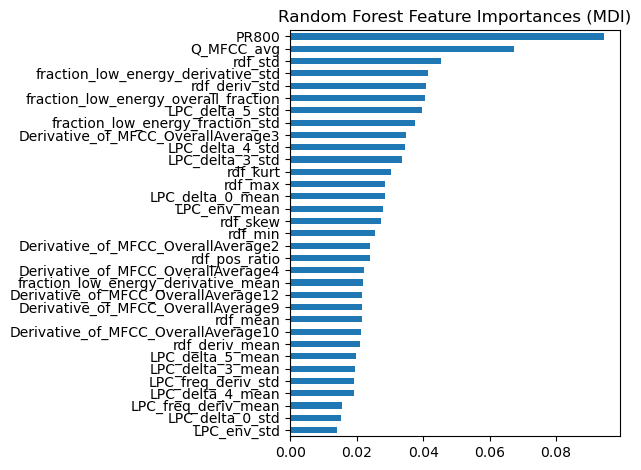

In [62]:
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()